In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Import libraries**





In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
from keras import applications
from keras.models import Model, Sequential
from keras import backend as k
from keras.layers import Activation
from keras.layers.core import Dense , Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.applications import efficientnet

from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
import cv2
from keras import optimizers
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob


In [ ]:
train_path = '/content/drive/MyDrive/my theses project/dataset/sixth dataset/sixth dataset/training data'
valid_path = '/content/drive/MyDrive/my theses project/dataset/sixth dataset/sixth dataset/validation data'
test_path = '/content/drive/MyDrive/my theses project/dataset/sixth dataset/sixth dataset/testing data'

# **2. Get Data**


In [ ]:
#define function to count images 
def count_image_files(folder_name, extensions=['jpg']):
    """Counts 1-level nested image files in a folder
    Arg:
        folder_name: name of folder to search
        extensions: array of image file extensions
    Returns:
        number of image files
    """
    from functools import reduce
    import glob
    return reduce((lambda x, y: x + y),
        [len(glob.glob('%s/**/*.%s' % (folder_name, ext), recursive=True))
            for ext in extensions])
    
# get images path and count number of images

dataset_path='/content/drive/MyDrive/my theses project/dataset/sixth dataset/sixth dataset'

train_folder = os.path.join(dataset_path, 'training data')
n_train_set = count_image_files(train_folder)
print('Training set size:', n_train_set)

validation_folder = os.path.join(dataset_path, 'validation data')#Validation
n_validation_set = count_image_files(validation_folder)
print('Validation set size:', n_validation_set)

test_folder = os.path.join(dataset_path, 'testing data')#test
n_test_set = count_image_files(test_folder)
print('test set size:', n_test_set)

Training set size: 2356
Validation set size: 1011
test set size: 685


## **3. Split Dataset into batches**

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(directory=train_path, target_size=(512,512), class_mode='categorical', batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(512,512), class_mode='categorical', batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(directory=test_path, target_size=(512,512), class_mode='categorical', batch_size=1, shuffle=False)

Found 2356 images belonging to 3 classes.
Found 1011 images belonging to 3 classes.
Found 685 images belonging to 3 classes.


# 4. Load MobileNet 1  

In [ ]:
# get MobileNet

print("loading model...")
efficientnet= applications.efficientnet.EfficientNetB7(include_top=False, weights='imagenet',input_shape=(512, 512, 3))
print("model loaded!!")
efficientnet.summary()

loading model...
258088960/258076736 [==============================] - 2s 0us/step
model loaded!!
Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0] 

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# get layers and add average pooling layer
x= efficientnet.layers[-3].output
x = GlobalAveragePooling2D()(x)
# add fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

pridiction=Dense(3, activation='softmax')(x)
model = Model(inputs=efficientnet.input, outputs=pridiction)

# add output layer
#predictions = Dense(3, activation='softmax')(x)

#model = Model(inputs=efficientnet.input, outputs=predictions)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [ ]:
len(model.layers)   

815

In [ ]:
for layer in model.layers[:-100]:
  layer.trainable=False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
#save model 

from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/my theses project/codes/4-training and validation and testing /deep learning/test test/efficient test test.json", "w") as json_file:
    json_file.write(model_json)

###################################################

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, min_delta=0.001) 
mc = ModelCheckpoint('/content/drive/MyDrive/my theses project/codes/4-training and validation and testing /deep learning/test test/efficient_weights test test.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.compile(optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
history= model.fit_generator(train_batches,steps_per_epoch=len(train_batches),validation_data=valid_batches,validation_steps=len(valid_batches),epochs=75,verbose=1,callbacks=[es,mc])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
74/74 [==============================] - 805s 10s/step - loss: 1.2228 - accuracy: 0.5699 - val_loss: 0.2121 - val_accuracy: 0.9199

Epoch 00001: val_accuracy improved from -inf to 0.91988, saving model to /content/drive/MyDrive/my theses project/codes/4-training and validation and testing /deep learning/test test/efficient_weights test test.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/75
74/74 [==============================] - 231s 3s/step - loss: 0.3004 - accuracy: 0.8946 - val_loss: 0.1352 - val_accuracy: 0.9575

Epoch 00002: val_accuracy improved from 0.91988 to 0.95747, saving model to /content/drive/MyDrive/my theses project/codes/4-training and validation and testing /deep learning/test test/efficient_weights test test.hdf5
Epoch 3/75
74/74 [==============================] - 234s 3s/step - loss: 0.0848 - accuracy: 0.9706 - val_loss: 0.1602 - val_accuracy: 0.9604

Epoch 00003: val_accuracy improved from 0.95747 to 0.96044, saving model to /content/drive/MyDrive/my theses project/codes/4-training and validation and testing /deep learning/test test/efficient_weights test test.hdf5
Epoch 4/75
74/74 [==============================] - 234s 3s/step - loss: 0.0546 - accuracy: 0.9839 - val_loss: 0.2364 - val_accuracy: 0.9436

Epoch 00004: val_accuracy did not improve from 0.96044
Epoch 5/75
74/74 [==============================] - 234s 3s/step - loss: 0.0776 -

In [ ]:
results = model.evaluate(valid_batches,batch_size=len(valid_batches))
print('val_loss: {:.4f} '.format( results[0]),' val_accuracy:{:.4f}'.format( results[1]*100))


# Evaluate on validation data
36/36 [==============================] - 25s 679ms/step - loss: 0.3022 - accuracy: 0.9759
val_loss: 0.3022   val_accuracy:97.5941


Maximum accuracy at epoch 31 = 0.9743


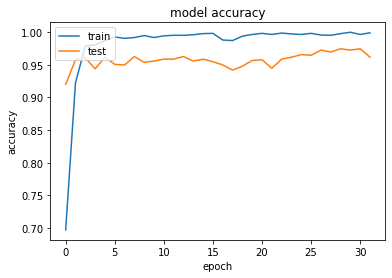

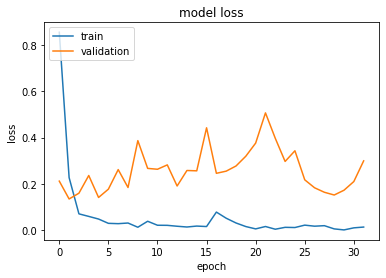

In [ ]:

max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

# ploting
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper left')
pyplot.show()


# **predction test**

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('/content/drive/MyDrive/my theses project/codes/4-training and validation and testing /deep learning/test test/efficient test test.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

classifier = model_from_json(loaded_model_json)
# load weights into new model
classifier.load_weights("/content/drive/MyDrive/my theses project/codes/4-training and validation and testing /deep learning/test test/efficient_weights test test.hdf5")
print("Loaded model from disk")
classifier.summary()

Loaded model from disk
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
_____________________________________________________________________

In [ ]:
test_labels =test_batches .classes


In [ ]:
n_test_set=len(test_labels)

In [ ]:
batch_size=1

In [ ]:
steps = n_test_set / batch_size
steps

685.0

In [ ]:
from keras import optimizers
adam = optimizers.Adam(lr=0.0001)
classifier.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
predictions_prob=classifier.predict_generator(test_batches,steps,verbose=1)
predictions_class=np.round(predictions_prob[:])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


685/685 [==============================] - 288s 339ms/step


In [ ]:
len(test_labels)

685

In [ ]:
predictions_prob

array([[1.94004551e-03, 7.17732415e-04, 9.97342288e-01],
       [1.60090979e-02, 1.23554803e-02, 9.71635461e-01],
       [9.99942541e-01, 4.51657688e-05, 1.22349411e-05],
       ...,
       [1.05732013e-13, 5.82907798e-16, 1.00000000e+00],
       [3.33909705e-14, 1.28854325e-17, 1.00000000e+00],
       [1.78631163e-18, 6.59934338e-23, 1.00000000e+00]], dtype=float32)

In [ ]:
predictions_class

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
prob_of_image=[]
for x in predictions_prob:
  if x[0]>x[1] and x[0]>x[2]:
    prob_of_image.append(x[0])
  elif x[1]>x[2]:
    prob_of_image.append(x[1])
  else: prob_of_image.append(x[2])


In [ ]:
pred_test=[]
for i in predictions_class:
  if i[0]==1:
    pred_test.append('0')
  elif i[1]==1:
    pred_test.append('1')
  else: pred_test.append('2')


act_test=[]
for i in test_labels:
  if i==0:
    act_test.append('0')
  elif i==1:
    act_test.append('1')
  elif i==2: act_test.append('2')

In [ ]:
print(len(act_test))
print(len(pred_test))

685
685


In [ ]:
cm=cm=confusion_matrix(pred_test,act_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label ')

Confusion matrix, without normalization
[[195   1   3]
 [ 10 228   0]
 [ 22   0 226]]


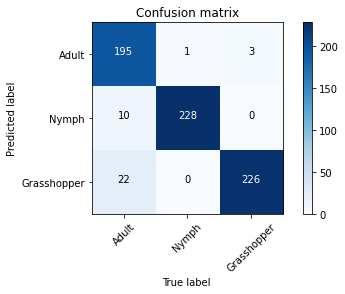

In [ ]:
classes =['Adult','Nymph',  'Grasshopper']

plot_confusion_matrix(cm, classes)


In [ ]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
print ('Report : ')
print (classification_report(act_test, pred_test,target_names=classes,digits=20 ))

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# F1_score 
F1_score = 2* TP/((2*TP)+FP+FN)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy = ', np.mean(ACC))
print('Sensitivity = ', np.mean(TPR))
print('Specificity = ', np.mean(TNR))
print('Precision = ', np.mean(PPV))
print('F1_score = ', np.mean(F1_score))





Report : 
                      precision    recall  f1-score   support

               Adult  0.97989949748743720992 0.85903083700440530102 0.91549295774647887480       227
               Nymph  0.95798319327731096262 0.99563318777292575401 0.97644539614561032259       229
         Grasshopper  0.91129032258064512906 0.98689956331877726203 0.94758909853249473354       229

            accuracy                      0.94744525547445257452       685
           macro avg  0.94972433778179776720 0.94718786269870269834 0.94650915080819464364       685
        weighted avg  0.94963623512572292729 0.94744525547445257452 0.94659970903611212467       685

Accuracy =  0.964963503649635
Sensitivity =  0.9497243377817978
Specificity =  0.9750180845257154
Precision =  0.9471878626987027
F1_score =  0.9465091508081946


In [ ]:
#save prediced value in excel
import pandas as pd
pd.set_option('display.max_rows', None)

columes = {'image_name':test_batches.filenames,'act_test':act_test,'prob_of_image':prob_of_image,'pred_test':pred_test}

df = pd.DataFrame(columes, columns = ['image_name','act_test','prob_of_image','pred_test'])
df.to_csv('/content/drive/MyDrive/my theses project/codes/4-training and validation and testing /deep learning/test test/efficient B7.csv',index=False, header=True)
#print(len(actual_label))

In [ ]:
df.head(500)

,image_name,act_test,prob_of_image,pred_test
0,DesertLocustAdult/Adult0.jpg,0,0.997342,2
1,DesertLocustAdult/Adult1.jpg,0,0.971635,2
2,DesertLocustAdult/Adult10.jpg,0,0.999943,0
3,DesertLocustAdult/Adult100.jpg,0,1.000000,0
4,DesertLocustAdult/Adult101.jpg,0,1.000000,0
5,DesertLocustAdult/Adult102.jpg,0,1.000000,0
6,DesertLocustAdult/Adult103.jpg,0,1.000000,0
7,DesertLocustAdult/Adult104.jpg,0,1.000000,0
8,DesertLocustAdult/Adult105.jpg,0,1.000000,0
9,DesertLocustAdult/Adult106.jpg,0,1.000000,0


# **Receiver Operating Characteristic (ROC)**

In [ ]:
actual_label_in_3_classes=[]
for i in test_labels:
  if i==0:
    actual_label_in_3_classes.append([1,0,0])
  elif i==1:
    actual_label_in_3_classes.append([0,1,0])
  elif i==2: actual_label_in_3_classes.append([0,0,1])

actual_label_in_3_classes= np.array(actual_label_in_3_classes)

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(actual_label_in_3_classes[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual_label_in_3_classes.ravel(), predictions_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Automatically created module for IPython interactive environment


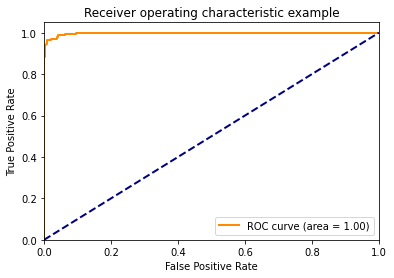

In [ ]:
#Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


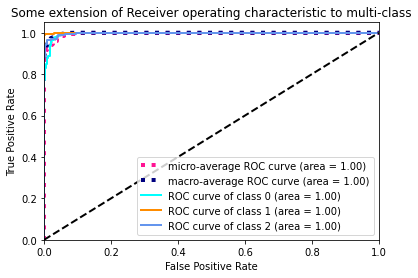

In [ ]:
#Plot ROC curves for the multilabel problem
n_classes=3 # NORMAL AND COVID AND PUNOMYA
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# **Area under ROC for the multiclass problem¶**
**The sklearn.metrics.roc_auc_score function can be used for multi-class classification. The multi-class One-vs-One scheme compares every unique pairwise combination of classes. In this section, we calculate the AUC using the OvR and OvO schemes. We report a macro average, and a prevalence-weighted average.**

In [ ]:
y_prob = predictions_prob
y_test=actual_label_in_3_classes
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.998086 (macro),
0.998091 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.998086 (macro),
0.998091 (weighted by prevalence)
